### Read transformed data

In [11]:
import pandas as pd

df = pd.read_csv("atp_transformed/2000-2024 players_2.csv")

df.head()

C:\Users\Rusty\AppData\Local\Temp\ipykernel_9068\3673202588.py:3: DtypeWarning: Columns (18,41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("atp_transformed/2000-2024 players_2.csv")


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,score,best_of,tourney_round,...,median_diff_rolling_mean_10,total_diff_rolling_mean_10,mean_tb_numb_rolling_mean_10,median_tb_numb_rolling_mean_10,total_tb_numb_rolling_mean_10,mean_tb_diff_rolling_mean_10,median_tb_diff_rolling_mean_10,total_tb_diff_rolling_mean_10,elo_next_match,player_hand_missing
0,1975-237,Sao Paulo WCT,Carpet,32.0,A,1975-03-10,2,6-1 6-1,3,R32,...,3.200000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
1,1975-2023,Fairfield,Carpet,32.0,A,1975-02-24,13,6-0 6-0,3,R32,...,4.700000,8.500000,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0
2,1975-436,Charlotte,Clay,32.0,A,1975-04-21,7,6-4 3-6 6-4,3,R32,...,3.416667,5.857143,0.0,0.0,0.0,0.0,0.0,0.0,1571.881887,0
3,1974-2030,Merion,Grass,64.0,A,1974-08-25,247,6-2 6-2,3,R64,...,2.428571,5.428571,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
4,1977-345,Monterrey WCT,Carpet,16.0,A,1977-02-28,4,6-0 6-1,3,R16,...,3.611111,7.200000,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177422 entries, 0 to 1177421
Columns: 132 entries, tourney_id to player_hand_missing
dtypes: float64(96), int64(16), object(20)
memory usage: 1.2+ GB


In [5]:
df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'score', 'best_of', 'tourney_round',
       ...
       'median_diff_rolling_mean_10', 'total_diff_rolling_mean_10',
       'mean_tb_numb_rolling_mean_10', 'median_tb_numb_rolling_mean_10',
       'total_tb_numb_rolling_mean_10', 'mean_tb_diff_rolling_mean_10',
       'median_tb_diff_rolling_mean_10', 'total_tb_diff_rolling_mean_10',
       'elo_next_match', 'player_hand_missing'],
      dtype='object', length=132)

#### Add Average Win Rate

In [34]:
df_copy = df.copy()

player_agg = (
    df.groupby('player_id')
      .agg(
          player_name=('player_name', 'first'),
          total_wins=('match_outcome', 'sum'),
          matches_played=('match_outcome', 'count')
      )
      .reset_index()
)

# Calculate average win rate
player_agg['average_win_rate'] = round(player_agg['total_wins'] / player_agg['matches_played'], 2)

# Merge average_win_rate back into the full dataframe copy
df_copy = df_copy.merge(player_agg[['player_id', 'average_win_rate']], on='player_id', how='left')

# Aggregated table for summaries
player_stats = player_agg[['player_id', 'player_name', 'total_wins', 'matches_played', 'average_win_rate']]

# Display the first few rows of the player_stats dataframe sorted by matches played
player_stats.sort_values(by='matches_played', ascending=False).head()

,player_id,player_name,total_wins,matches_played,average_win_rate
1656,103819,Roger Federer,1237,1492,0.83
2742,104925,Novak Djokovic,1183,1420,0.83
2566,104745,Rafael Nadal,1160,1410,0.82
1728,103893,Paolo Lorenzi,704,1309,0.54
1804,103970,David Ferrer,858,1298,0.66


#### Average Win Rate per surface type

In [ ]:
# check all unique surface types
df_copy['surface'].unique()

# Average Win Rate per surface type
surface_win_rate = (
    df_copy.groupby(['player_id', 'surface'])
           .agg(
               wins=('match_outcome', 'sum'),
               matches=('match_outcome', 'count')
           )
           .reset_index()
)

# Calculate win rate (wins / matches)
surface_win_rate['win_rate'] = surface_win_rate['wins'] / surface_win_rate['matches']

# Pivot to wide format so each surface becomes its own column with win rate values
surface_win_rate_wide = surface_win_rate.pivot(index='player_id', columns='surface', values='win_rate').reset_index()

# Prefix column names to avoid collisions and for clarity
surface_win_rate_wide = surface_win_rate_wide.rename(columns=lambda x: f'win_rate_{x}' if x != 'player_id' else x)

# Merge the wide-format surface win rates back into the main df_copy
df_copy = df_copy.merge(surface_win_rate_wide, on='player_id', how='left')

# Fill NaNs (players who never played a given surface) with 0 and round to 2 decimals
win_rate_cols = [c for c in df_copy.columns if c.startswith('win_rate_')]
if win_rate_cols:
    df_copy[win_rate_cols] = df_copy[win_rate_cols].fillna(0).round(2)

# Display the updated df_copy with new surface win rate columns for unique players sorted by win_rate_Clay and only showing columns: player_name and win rate columns. Also over 50 matches
df_copy_filtered = df_copy[df_copy['matches'] > 50]  
df_copy_filtered[['player_name'] + win_rate_cols].drop_duplicates().sort_values(by='win_rate_Clay', ascending=False).head() 

KeyError: 'matches_played'

#### Wins against a top 10 opponent

In [20]:
# Get winners and losers with their tourney_match_id and rank
winners = df_copy[df_copy['match_outcome'] == 1][['player_tourney_match_id', 'player_id']].copy()
losers = df_copy[df_copy['match_outcome'] == 0][['player_tourney_match_id', 'player_rank']].copy()

# Extract just the tourney match ID (everything after the first ':')
winners['tourney_match_id'] = winners['player_tourney_match_id'].str.split(':').str[1:]
winners['tourney_match_id'] = winners['tourney_match_id'].str.join(':')

losers['tourney_match_id'] = losers['player_tourney_match_id'].str.split(':').str[1:]
losers['tourney_match_id'] = losers['tourney_match_id'].str.join(':')

# Rename the loser's rank column to avoid confusion
losers = losers.rename(columns={'player_rank': 'opponent_rank'})

# Merge on the tourney_match_id
winner_vs_loser = pd.merge(
    winners[['player_id', 'tourney_match_id']], 
    losers[['tourney_match_id', 'opponent_rank']], 
    on='tourney_match_id', 
    how='inner'
)

# Create wins_against_top_10 column and aggregate
winner_vs_loser['win_against_top_10'] = (winner_vs_loser['opponent_rank'] <= 10).astype(int)
top_10_wins = winner_vs_loser.groupby('player_id')['win_against_top_10'].sum().reset_index()

# Merge back into df_copy
df_copy = df_copy.merge(top_10_wins, on='player_id', how='left')
df_copy['win_against_top_10'] = df_copy['win_against_top_10'].fillna(0).astype(int)

# Display the updated df_copy with the new column sorted by win_against_top_10 for unique players and showing only columns: player_name and win_against_top_10
df_copy[['player_name', 'win_against_top_10']].drop_duplicates().sort_values(by='win_against_top_10', ascending=False).head()

,player_name,win_against_top_10
488301,Novak Djokovic,259
215917,Roger Federer,223
446867,Rafael Nadal,186
485203,Andy Murray,105
386052,Stan Wawrinka,63


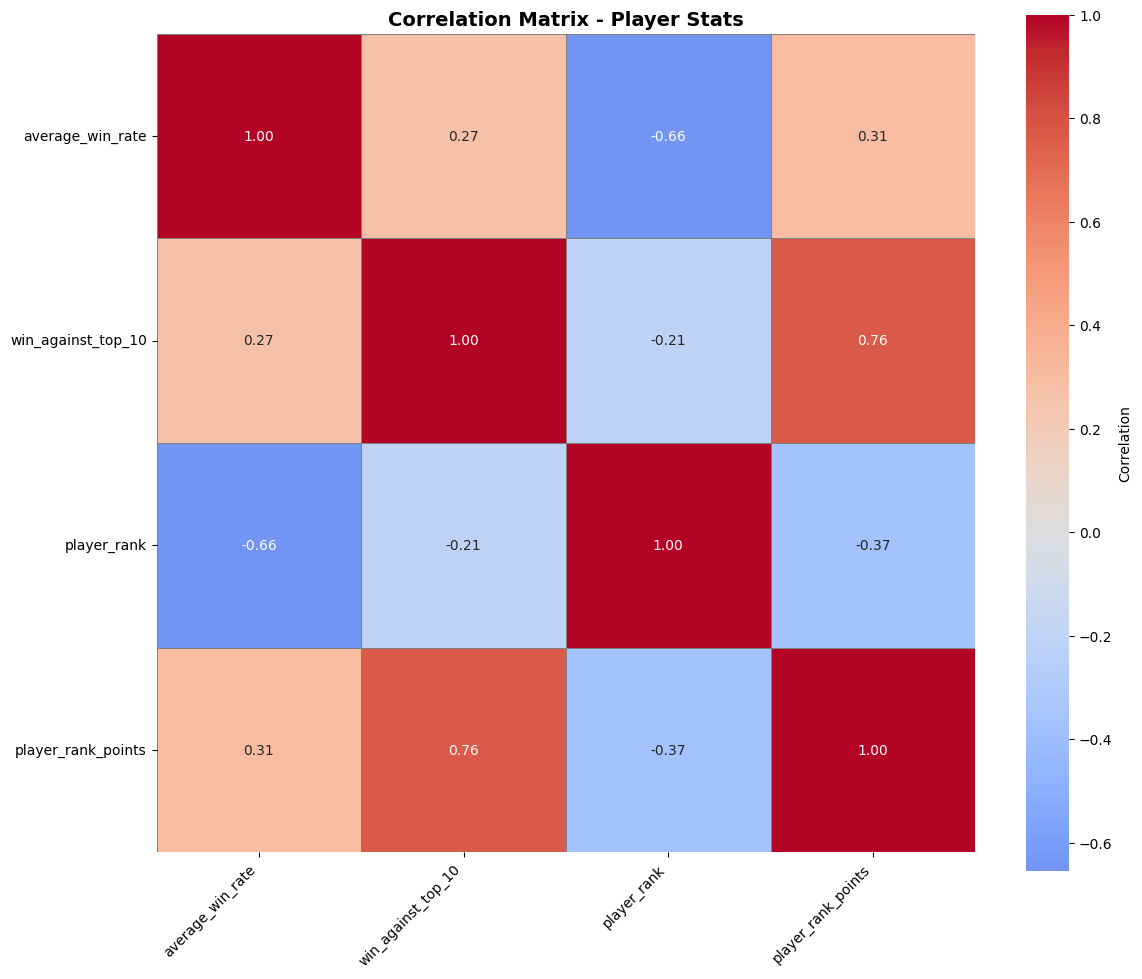

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix of numeric columns in player_stats
cols = ['average_win_rate', 'win_against_top_10', 'player_rank', 'player_rank_points']
corr_matrix = df_copy[cols].corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
            fmt='.2f', cbar_kws={'label': 'Correlation'}, linewidths=0.5, linecolor='gray')
plt.title('Correlation Matrix - Player Stats', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()